# AMATH 482 Homework 2 - *Digit Classification*
## Lang Qin

# Environment Setup

We first connect our notebook to personal google drive.

In [1]:
from google.colab import drive

# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')

Mounted at /content/drive


Then, we read in the given the dataset. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# load training and test sets 

path_to_train = '/content/drive/My Drive/AMATH 482/HW2/MNIST_training_set.npy'
path_to_test = '/content/drive/My Drive/AMATH 482/HW2/MNIST_test_set.npy'

d_train = np.load(path_to_train, allow_pickle=True)
d_test = np.load(path_to_test, allow_pickle=True)

Notice that *d_train* and *d_test* consist of features and labels. We need
to separate them for further analysis.

In [3]:
# Extract features and labels
X_train = d_train.item().get('features')
Y_train = d_train.item().get('labels')

print("Shape of training features: " + str(X_train.shape))
print("Shape of training labels: " + str(Y_train.shape))

X_test = d_test.item().get('features')
Y_test = d_test.item().get('labels')

print("Shape of testing feature: " + str(X_test.shape))
print("Shape of testing labels: " + str(Y_test.shape))

Shape of training features: (2000, 256)
Shape of training labels: (2000,)
Shape of testing feature: (500, 256)
Shape of testing labels: (500,)


Now we are ready to investigate the digits.

# Dimensionality of $X_{train}$ by PCA

The first step is to perform Singular Value Decomposition of mean-subtracted
training data.

In [4]:
import numpy.matlib as matlib

# compute svd of centered data
ave_data = np.mean(X_train, 0)
centered_data = X_train - matlib.repmat(ave_data, 2000, 1)
U, S, Vt = np.linalg.svd(centered_data, full_matrices=False)

# view the shape of U, S ,Vt
print(U.shape, S.shape, Vt.shape)

(2000, 256) (256,) (256, 256)


In [5]:
U[:,0:16].shape

(2000, 16)

Plot the averaged digit and first 16 PCA modes as 16×16 images.

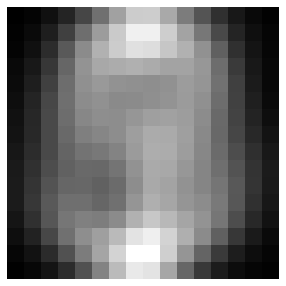

In [6]:
# plot averaged digit image
fig1 = plt.figure(figsize=(5,5))

ax1 = fig1.add_subplot(111)
img_avg = ax1.imshow(np.reshape(ave_data, (16,16)))
img_avg.set_cmap('gray')
plt.axis('off')

plt.show()

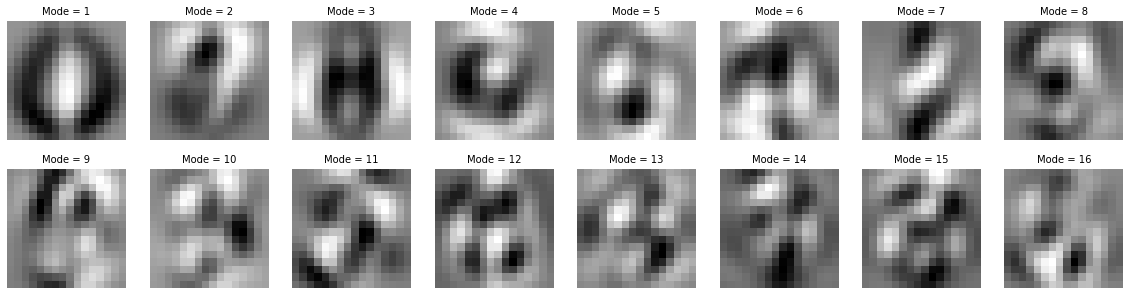

In [7]:
# plot first 16 PCA modes
fig, ax = plt.subplots(2, 8, figsize=(20,5))

for i in range(2):
    for j in range(8):
        ax[i][j].imshow(np.reshape(Vt[i*8+j, :], (16,16)), cmap='gray')
        ax[i][j].set_title("Mode = " + str(i*8+j+1), fontsize=10)
        ax[i][j].axis('off')

plt.show()	

Plot the singular values to see the effective dimension of the data set.

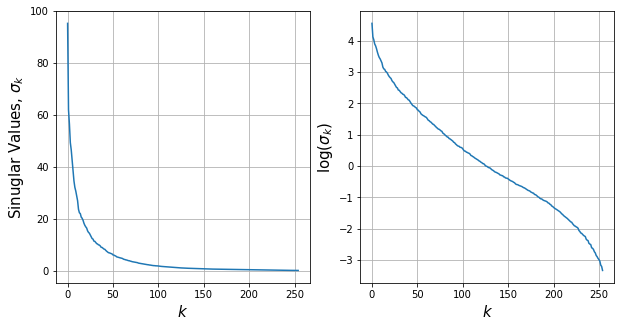

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))

# plot singular values
ax[0].plot(S[:255])
ax[0].set_xlabel('$k$', fontsize=15)
ax[0].set_ylabel('Sinuglar Values, $\sigma_k$', fontsize=15)
ax[0].grid()

# plot log singular values
ax[1].plot(np.log(S)[:255])
ax[1].set_xlabel('$k$', fontsize=15)
ax[1].set_ylabel('$\log(\sigma_k)$', fontsize=15)
ax[1].grid()


# Mode Approximation

Here we will compute the number of PCA modes necessary to approximate
$X_{train}$ up to 60%, 80%, and 90% in the Frobenius norm.

In [9]:
# Frobenius norm of X_train
X_train_fn = np.linalg.norm(S)

# record approximations percentage
Fns = list()

# compute Frobenius norm corresponds to each rank
for i in range(256):
    Fns.append(np.linalg.norm(np.diag(S[:i+1])) / X_train_fn)


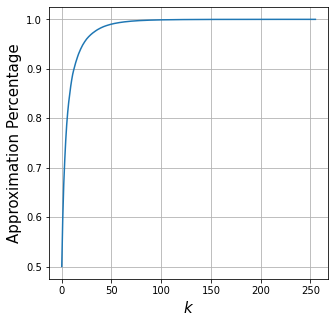

In [10]:
# plot approximation percentage vs modes
fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(Fns)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('Approximation Percentage', fontsize=15)
ax.grid()

In [11]:
# fnd number of mode corresponds to 60%
i = 0
while Fns[i] < 0.6:
    i += 1
print("Up to 60%: " + str(i+1))

# fnd number of mode corresponds to 80%
i = 0
while Fns[i] < 0.8:
    i += 1
print("Up to 80%: " + str(i+1))

# fnd number of mode corresponds to 90%
i = 0
while Fns[i] < 0.9:
    i += 1
print("Up to 90%: " + str(i+1))

Up to 60%: 3
Up to 80%: 7
Up to 90%: 14


# Classification

In this section, we will develop functions to distinguish digit images
via PCA and Ridge regression.


## Feature Extraction of Given Labels

Firstly, we implement a function to extract features of a label.

In [12]:
def feature_extract(data, target_labels):
    # extract X, Y
    X = data.item().get('features')
    Y = data.item().get('labels')

    # extract values
    idx_0 = np.where(Y == target_labels[0])
    idx_1 = np.where(Y == target_labels[1])

    idx = np.append(np.asarray(idx_0).flatten(), np.asarray(idx_1).flatten())
    X_target = X[idx, :]
    Y_target = Y[idx,]

    return (X_target, Y_target)


Now, extract features and labels of the digit 1 and 8 from the training data set.

In [13]:
features_train_18, labels_train_18 = feature_extract(d_train, (1,8))

## Projection onto the PCA Coefficints

In [14]:
A_train_18 = (Vt[0:16, :] @ features_train_18.T).T
A_train_18.shape

(455, 16)

## Classification by Ridge Regression

**Classification of Digit 1 and 8**

We firstly relabel the features to perform binary classification of the
digits **1** and **8**.


In [15]:
# assign -1 to digit 1
labels_train_18[np.where(labels_train_18 == 1)] = -1

# assign 1 to digit 8
labels_train_18[np.where(labels_train_18 == 8)] = 1

Then we fit the Ridge regression model. 

In [35]:
from sklearn import linear_model

# initialize alpha values
l = np.linspace(-15, 30, 50)
alpha_vals = 2 ** l

# fit the model
model = linear_model.RidgeCV(alphas=alpha_vals)
model.fit(A_train_18, labels_train_18)

RidgeCV(alphas=array([3.05175781e-05, 5.76774675e-05, 1.09008987e-04, 2.06024287e-04,
       3.89380805e-04, 7.35920087e-04, 1.39087076e-03, 2.62871131e-03,
       4.96819934e-03, 9.38977382e-03, 1.77464402e-02, 3.35403329e-02,
       6.33903992e-02, 1.19806286e-01, 2.26430916e-01, 4.27948829e-01,
       8.08812697e-01, 1.52863599e+00, 2.88908419e+00, 5.46029763e+00,
       1.03198274e+01, 1.95042185e+0...
       1.31673054e+02, 2.48858814e+02, 4.70337000e+02, 8.88925293e+02,
       1.68004681e+03, 3.17524690e+03, 6.00113807e+03, 1.13420025e+04,
       2.14361040e+04, 4.05137062e+04, 7.65699023e+04, 1.44715221e+05,
       2.73508186e+05, 5.16923705e+05, 9.76973012e+05, 1.84645482e+06,
       3.48975392e+06, 6.59554856e+06, 1.24654236e+07, 2.35593421e+07,
       4.45265737e+07, 8.41541225e+07, 1.59049209e+08, 3.00599070e+08,
       5.68124805e+08, 1.07374182e+09]))

Score our model by Mean Squre Error.

In [36]:
from sklearn.metrics import mean_squared_error

# training mean square error
mean_squared_error(y_true=labels_train_18, y_pred=model.predict(A_train_18))

0.07549164234003777

Now, use the trained model to predict our testing data to evaluate our model.

In [37]:
# extract testing data
features_test_18, labels_test_18 = feature_extract(d_test, (1,8))

A_test_18 = (Vt[0:16, :] @ features_test_18.T).T

labels_test_18[np.where(labels_test_18 == 1)] = -1  # assign -1 to digit 1
labels_test_18[np.where(labels_test_18 == 8)] = 1  # assign 1 to digit 8

# training mean square error
mean_squared_error(y_true=labels_test_18, y_pred=model.predict(A_test_18))

0.08257789655567387

**Classification of Digit 3 and 8**

In [38]:
# extract and preprocess training data
features_train_38, labels_train_38 = feature_extract(d_train, (3,8))

# PCA projection
A_train_38 = (Vt[0:16, :] @ features_train_38.T).T

labels_train_38[np.where(labels_train_38 == 3)] = -1  # assign -1 to digit 1
labels_train_38[np.where(labels_train_38 == 8)] = 1  # assign 1 to digit 8

# fit the model
model.fit(A_train_38, labels_train_38)

# training mean square error
mean_squared_error(y_true=labels_train_38, y_pred=model.predict(A_train_38))

0.18286929272609048

In [39]:
# extract and preprocess test data
features_test_38, labels_test_38 = feature_extract(d_test, (3,8))

# PCA projection
A_test_38 = (Vt[0:16, :] @ features_test_38.T).T

labels_test_38[np.where(labels_test_38 == 3)] = -1  # assign -1 to digit 1
labels_test_38[np.where(labels_test_38 == 8)] = 1  # assign 1 to digit 8

# training mean square error
mean_squared_error(y_true=labels_test_38, y_pred=model.predict(A_test_38))

0.26103879245043504

**Classification of Digit 2 and 7**

In [40]:
# extract and preprocess training data
features_train_27, labels_train_27 = feature_extract(d_train, (2,7))

# PCA projection
A_train_27 = (Vt[0:16, :] @ features_train_27.T).T

labels_train_27[np.where(labels_train_27 == 2)] = -1  # assign -1 to digit 2
labels_train_27[np.where(labels_train_27 == 7)] = 1  # assign 1 to digit 7

# fit the model
model = linear_model.RidgeCV(alphas=alpha_vals)
model.fit(A_train_27, labels_train_27)

# training mean square error
mean_squared_error(y_true=labels_train_27, y_pred=model.predict(A_train_27))

0.09214730483219917

In [41]:
# extract and preprocess test data
features_test_27, labels_test_27 = feature_extract(d_test, (2,7))

# PCA projection
A_test_27 = (Vt[0:16, :] @ features_test_27.T).T

labels_test_27[np.where(labels_test_27 == 2)] = -1  # assign -1 to digit 2
labels_test_27[np.where(labels_test_27 == 7)] = 1  # assign 1 to digit 7

# training mean square error
mean_squared_error(y_true=labels_test_27, y_pred=model.predict(A_test_27))

0.13355454164989142